This notebook is for organism property information for all BRENDA sequences.<br/><br/>Copyright (C) 2019-2021  Martin Engqvist Lab<br/>This program is free software: you can redistribute it and/or modify<br/>it under the terms of the GNU General Public License as published by<br/>the Free Software Foundation, either version 3 of the License, or<br/>(at your option) any later version.<br/>This program is distributed in the hope that it will be useful,<br/>but WITHOUT ANY WARRANTY; without even the implied warranty of<br/>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br/>GNU General Public License for more details.<br/>You should have received a copy of the GNU General Public License<br/>along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


folder_name = 'brenda_2019_2'
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))

print('Standard variables loaded, you are good to go!')

Standard variables loaded, you are good to go!


In [2]:
from orgtools import topfunctions, org_tax, uid_tax
from brenparse import parser
import re
import multiprocessing


import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from Bio import SeqIO

from tqdm import tqdm
import time


# Outline
This notebook is used to:

(1) Check each EC class for how many enzymes have been characterized and how many of those have UniProt identifiers

(2) To cluster the protein sequences of each EC class down to 90% (and add back any known protein sequence that might have been lost in the clustering)

(3) To find the domain of life for as many protein sequences as possible

# (1)

# Load SwissProt data

### We load the set of proteins from SwissProt that are designated as having evidence on the protein level

In [3]:
def load_swissprot():
    '''
    Load identifiers which are marked as characterized in SwissProt.
    '''
       
    # get entries WITH uid
    ec_org_uid_data = {}
    with open(swissprot_file, 'r') as f:
        f.readline()
        counter = 0
        
        for line in f:
            counter += 1
            uid, ec, org, orgid = line.strip().split('\t')
            org = ' '.join(org.lower().split()[:2])
            
            if ec_org_uid_data.get(ec) is None:
                ec_org_uid_data[ec] = {}
                
            if ec_org_uid_data[ec].get(org) is None:
                ec_org_uid_data[ec][org] = {'uids':set([]), 'domain':None}
                
            ec_org_uid_data[ec][org]['uids'].add(uid)
            
    print('{} SwissProt entries with uid'.format(counter))
                
    return {}, ec_org_uid_data



swissprot_file = join(RAW_EXTERNAL, 'SwissProt-2020_02-protein-evidence.tsv') 
ec_org_data, ec_org_uid_data = load_swissprot()

34498 SwissProt entries with uid


In [4]:
swiss_uid = []
for ec in ec_org_uid_data.keys():
    for org in ec_org_uid_data[ec]:
        swiss_uid += list(ec_org_uid_data[ec][org]['uids'])
        
print('{} unique identifiers in SwissProt'.format(len(list(set(swiss_uid)))))

30574 unique identifiers in SwissProt


# Analysis for BRENDA 2019.2

## First part entails parsing the html files

### Parse all the BRENDA html files such that I can tell which uids are associated with experimental results
Two files are generated from this. One file contains all the organism names for enzymes tested but which does not have a uid. The other file contains the uid and organism names for tested enzymes that does have a uid.

**Generates:** "ec_data_all_orgs.tsv" and "ec_data_uid_orgs.tsv" outfiles.

In [5]:

def load_uid_org_from_file(ec_org_data={}, ec_org_uid_data={}):
    '''
    Load already parsed data from local file
    '''
    # get entries WITHOUT uid
    with open(outfile_all, 'r') as f:
        f.readline()
        
        for line in f:
            ec, org = line.strip().split('\t')
            
            if ec_org_data.get(ec) is None:
                ec_org_data[ec] = {}
            ec_org_data[ec][org] = {'uids':None, 'domain':None}
         
        
    # get entries WITH uid
    with open(outfile_uid, 'r') as f:
        f.readline()
        counter = 0
        
        for line in f:
            counter += 1
            ec, org, uid = line.strip().split('\t')
            
            if ec_org_uid_data.get(ec) is None:
                ec_org_uid_data[ec] = {}
                
            if ec_org_uid_data[ec].get(org) is None:
                ec_org_uid_data[ec][org] = {'uids':set([]), 'domain':None}
                
            ec_org_uid_data[ec][org]['uids'].add(uid)
    print('{} BRENDA entries with uid'.format(counter))
                
    return ec_org_data, ec_org_uid_data
    

    
def get_uid_org_from_html(data={}):
    '''
    Parse each html file to get uid and organism for cases
    where experiments have been performed.
    '''
    filepath = join(RAW_EXTERNAL, folder_name, 'html_data')
    data = {}

    # go through all html files and parse them
    all_files = sorted(os.listdir(filepath))
    for fi in all_files:
        print(fi)
        soup_obj = parser.open_ec(join(filepath, fi))
        orgs = parser.Organism(soup_obj)
        data[fi.replace('.html', '')] = orgs.get_data(uid_orgs_only=False)


    # organize all data in a flat format
    out_strings = ['ec\torganism']
    for ec in sorted(data.keys()):

        if data[ec] is None:
            continue

        for org in data[ec]:
            out_strings.append('%s\t%s' % (ec, org))

    # write to file 
    with open(outfile_all, 'w') as f:
        f.write('\n'.join(out_strings))



    # organize uid data in a flat format
    out_strings = ['ec\torganism\tuid']
    for ec in sorted(data.keys()):

        if data[ec] is None:
            continue

        for org in data[ec]:            
            for uid in data[ec][org]:

                if uid == ['unknown']:
                    continue

                out_strings.append('%s\t%s\t%s' % (ec, org, uid))

    # write to file 
    with open(outfile_uid, 'w') as f:
        f.write('\n'.join(out_strings))
        


outfile_all = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_all_orgs.tsv')
outfile_uid = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_uid_orgs.tsv')

# only generate outfile if it does not exist
if exists(outfile_all) and exists(outfile_uid):
    ec_org_data, ec_org_uid_data = load_uid_org_from_file()
    print('Will not parse html because outfiles already exist')
    
else:
    print('Parsing html to generate outfiles')
    get_uid_org_from_html()
    ec_org_data, ec_org_uid_data = load_uid_org_from_file()
    print('Done')

33442 BRENDA entries with uid
Will not parse html because outfiles already exist


In [6]:
bren_uid = []
for ec in ec_org_uid_data.keys():
    for org in ec_org_uid_data[ec]:
        bren_uid += list(ec_org_uid_data[ec][org]['uids'])
        
print('{} unique uids in BRENDA'.format(len(list(set(bren_uid)))))

31287 unique uids in BRENDA


In [7]:
print('{} overlapping uids in the two datasets'.format(len(set(swiss_uid) & set(bren_uid))))

11498 overlapping uids in the two datasets


#### Plot some figures for the html data with no identifiers

,ec,organism
0,1.1.1.1,Acetobacter pasteurianus
1,1.1.1.1,Aeropyrum pernix
2,1.1.1.1,Anaerobium acetethylicum
3,1.1.1.1,Anastrepha obliqua
4,1.1.1.1,Aspergillus nidulans


,ec,organism
69954,7.6.2.9,Listeria monocytogenes
69955,7.6.2.9,Pseudomonas syringae
69956,7.6.2.9,Aphanothece halophytica
69957,7.6.2.9,Escherichia coli
69958,7.6.2.9,Salmonella enterica


,ec,organism
count,69959,69959
unique,6757,10148
top,4.1.1.39,Homo sapiens
freq,300,1708


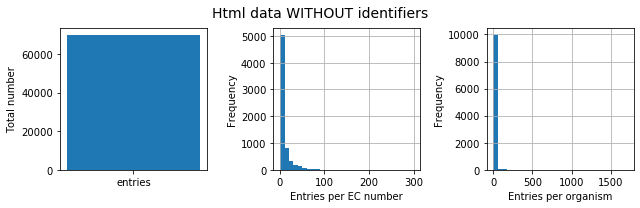

In [8]:

filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_all_orgs.tsv')
df = pd.read_csv(filepath, sep='\t')

display(df.head())
display(df.tail())
display(df.describe())

fig = plt.figure(figsize=(9, 3))

st = fig.suptitle("Html data WITHOUT identifiers", fontsize=14)

plt.subplot(1, 3, 1)
plt.bar(x='entries', height=df['ec'].count(), width=0.3)
plt.ylabel('Total number')


plt.subplot(1, 3, 2)
df['ec'].value_counts().hist(bins=30)
plt.xlabel('Entries per EC number')
plt.ylabel('Frequency')


plt.subplot(1, 3, 3)
df['organism'].value_counts().hist(bins=30)
plt.xlabel('Entries per organism')
plt.ylabel('Frequency')

plt.tight_layout()

# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.85)


#### Plot some figures for the html data with identifiers

,ec,organism,uid
0,1.1.1.1,Aeropyrum pernix,Q9Y9P9
1,1.1.1.1,Anaerobium acetethylicum,A0A1D3TV27
2,1.1.1.1,Blastobotrys adeninivorans,A0A060TBM3
3,1.1.1.1,Candida albicans,A0A1D8PP43
4,1.1.1.1,Columba livia,P86883


,ec,organism,uid
33437,7.6.2.9,Bacillus subtilis,Q45462
33438,7.6.2.9,Lactococcus lactis,Q7DAU8
33439,7.6.2.9,Lactococcus lactis,Q9KIF7
33440,7.6.2.9,Pseudomonas syringae,Q87WH5
33441,7.6.2.9,Aphanothece halophytica,Q0PCR9


,ec,organism,uid
count,33442,33442,33442
unique,5150,4152,31287
top,2.7.11.1,Homo sapiens,Q975F9
freq,336,2636,11


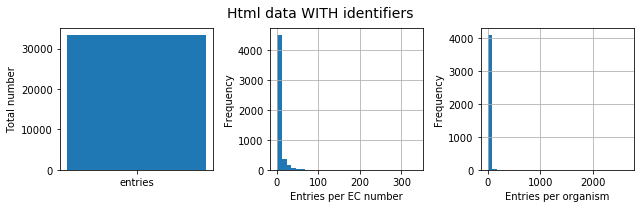

In [9]:

filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_uid_orgs.tsv')
df = pd.read_csv(filepath, sep='\t')

display(df.head())
display(df.tail())
display(df.describe())

fig = plt.figure(figsize=(9, 3))

st = fig.suptitle("Html data WITH identifiers", fontsize=14)

plt.subplot(1, 3, 1)
plt.bar(x='entries', height=df['ec'].count(), width=0.3)
plt.ylabel('Total number')


plt.subplot(1, 3, 2)
df['ec'].value_counts().hist(bins=30)
plt.xlabel('Entries per EC number')
plt.ylabel('Frequency')


plt.subplot(1, 3, 3)
df['organism'].value_counts().hist(bins=30)
plt.xlabel('Entries per organism')
plt.ylabel('Frequency')

plt.tight_layout()

# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.85)

### Get all uids from html using regex

This is an alternate approach to parsing the html structure. Mostly intended for the purpose of later checking whether I got all the identifiers that I was supposed to get.

**Generates:** The "ec_uid_characterized_regex_from_html.tsv" outfie.

In [10]:

def get_all_uniprot_id():
    '''
    Use regex to get all the uniprot identifiers. 
    Intended as an alternate method that does not 
    depend on parsing the html.
    '''
    outfile = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_uid_characterized_regex_from_html.tsv')
    
    # only generate outfile if it does not exist
    if exists(outfile):
        print('Skipping %s because it already exists' % outfile)
        return
    print('Generating %s' % outfile)

    #open the list of EC numbers and find all
    filepath = join(RAW_EXTERNAL, folder_name, 'all_enzymes.php.html')
    with open(filepath, 'r') as f:
        data = f.read()
    all_ec = set(re.findall('[0-9]+\.[0-9]+\.[0-9]+\.[0-9a-zA-Z]+', data))

    total = len(list(all_ec))
    print('Number of EC: %s' % total)

    #process each of these
    data = {}
    counter = 0
    for ec in sorted(list(all_ec)):
        print('processing', ec)
        html_doc = join(RAW_EXTERNAL, folder_name, 'html_data', '%s.html' % ec)

        #read the html page
        with open(html_doc, 'rb') as f:
            document = f.read().decode('utf-8', 'ignore')

        #http://www.uniprot.org/help/accession_numbers
        m = re.findall('[OPQ][0-9](?:[A-Z0-9]){3}[0-9]|[A-NR-Z][0-9](?:[A-Z][A-Z0-9]{2}[0-9]){1,2}', document)
        data[ec] = set(m)

    #count how many
    with open(outfile, 'w') as f:
        f.write('ec\tuid\n')

        for ec in sorted(data.keys()):
            if data[ec] == set([]):
                f.write('%s\t%s\n' % (ec, 'NA'))
            else:
                for uid in data[ec]:
                    f.write('%s\t%s\n' % (ec, uid))
                    
    print('Done')



get_all_uniprot_id()

Skipping /data/projects/test/analyze_1.1.3.15/data/intermediate/BRENDA_for_paper/parsed_info/ec_uid_characterized_regex_from_html.tsv because it already exists


# (2)

## Second part entails processing fasta files

### Cluster the sequences in each EC fasta file at a specific identity level to remove redundancy
I want to remove redundancy within each EC class and will therefore use CD-HIT to cluster the sequences at various identity levels.

**Generates:** Clustered fasta files at 100% and 90% identity.

In [11]:

def run_cd_hit(infile, outfile, cutoff, memory):
    '''
    Execute a single cdhit command on the command line.
    '''
    # get the right word size for the cutoff
    if cutoff < 0.5:
        word = 2
    elif cutoff < 0.6:
        word = 3
    elif cutoff < 0.7:
        word = 4
    else:
        word = 5


    my_cmd = 'cd-hit -i %s -o %s -c %s -n %s -T 1 -M %s' % (infile, outfile, cutoff, word, memory)
    os.system(my_cmd)



def cd_hit_ec(start_filepath, filepath, ec):
    '''
    Run cd-hit on an ec number, using different identity levels.
    '''
    mem = 2000 # memory in mb

    cutoff = 1.0
    outfile = join(filepath, '%s_clustered_sequences_%s.fasta' % (ec, str(int(cutoff*100))))
    if not exists(outfile):
        run_cd_hit(infile=join(start_filepath, '%s.fasta' % ec), outfile=outfile, cutoff=cutoff, memory=mem)

    cutoff = 0.9
    outfile = join(filepath, '%s_clustered_sequences_%s.fasta' % (ec, str(int(cutoff*100))))
    if not exists(outfile):
        run_cd_hit(infile=join(filepath, '%s_clustered_sequences_100.fasta' % ec), outfile=outfile, cutoff=cutoff, memory=mem)



def cd_hit_worker(args):
    '''
    A worker function to enable multiprocessing
    '''
    start_filepath, filepath, ec = args
    cd_hit_ec(start_filepath=start_filepath, filepath=filepath, ec=ec)


def run_all():
    # get all ec numbers
    start_filepath = join(RAW_EXTERNAL, folder_name, 'sequence_data')
    all_ec = [s.replace('.fasta', '') for s in os.listdir(start_filepath)]

    # create folder
    out_folder = join(INTERMEDIATE, 'BRENDA_for_paper', 'ec_identity_clustering')
    if not exists(out_folder):
        os.makedirs(out_folder)
    
    # get all parameters together
    data = []
    for ec in all_ec:
        data.append( (start_filepath, out_folder, ec) )

    #make a process pool that can be used to distribute work on all cores
    num_cores = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(num_cores)
    pool.map(cd_hit_worker, data)

    
run_all()
print('Done')

Done


### Add back characterized sequences
When clustering I likely lost some of the sequences that have been characterized. To be able to calculate how identical other enzymes are to them I need to add these back into the fasta files.

**Generates:** New fasta files with the word "augmented" added at the end of the filename.

In [12]:
# first get a list of the ones missing from each ec ##

def get_characterized():
    # get a dictionary of characterized identifiers from BRENDA
    characterized = {}
    with open(join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_uid_orgs.tsv'), 'r') as f:
        f.readline()

        for line in f:
            ec, org, uid = line.rstrip().split('\t')

            if characterized.get(ec) is None:
                characterized[ec] = set([])
            characterized[ec].add(uid)
            
    # get all characterized identifiers from SwissProt
    with open(join(RAW_EXTERNAL, 'SwissProt-2020_02-protein-evidence.tsv'), 'r') as f:
        f.readline()
        
        for line in f:
            uid, ec, org, orgid = line.strip().split('\t')
            
            if characterized.get(ec) is None:
                characterized[ec] = set([])
            characterized[ec].add(uid)
            
    return characterized
        
    
    
def get_all():
    '''
    Go through each clustered fasta file and collect all
    the identifiers.
    '''
    filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'ec_identity_clustering')
    files = os.listdir(filepath)
    all_ = {}

    print('Finding all')
    for fi in sorted(files):
        if fi.endswith('clustered_sequences_90.fasta'):
            ec = fi.split('_')[0]
            all_[ec] = []

            fasta_filepath = join(filepath, fi)
            fasta = SeqIO.parse(fasta_filepath, "fasta")

            # go through each entry in the fasta
            for record in fasta:
                header = record.description
                uid = header.rstrip().split(';')[0]
                all_[ec].append(uid)

    print('Done')     
    
    return all_


def get_missing():
    '''
    Check whether any of the characterized sequences
    are missing from the fasta files.
    '''
    print('Finding missing')
    missing = {}
    for ec in sorted(all_.keys()):
        
        if characterized.get(ec) is None:
            missing[ec] = set([]) - set(all_[ec])
        else:
            missing[ec] = set(characterized[ec]) - set(all_[ec])
            
    print('Done')
    return missing


def get_seq_from_uniprot(uid):
    '''
    Sequences for any missing identifiers are retrieved from UniProt
    '''
    seq_folder = join(RAW_EXTERNAL, 'missing_sequences')
    
    # do I have a file there already?
    filepath = join(seq_folder, '%s.fasta' % uid)

    if not exists(filepath):
        url = 'http://purl.uniprot.org/uniprot/%s.fasta' % uid
        print('downloading %s' % uid)
        mycmd = 'wget --retry-connrefused --waitretry=1 --read-timeout=2 --timeout=15 -t 100 -O %s %s' % (filepath, url)
        os.system(mycmd)
        print('done')
        
    
    # sometimes these are obsolete and must be fetched from uniparc
    if not os.path.getsize(filepath) > 0:
        url = 'https://www.uniprot.org/uniparc/%s.fasta' % uid
        print('downloading obsolete from uniparc %s' % uid)
        mycmd = 'wget --retry-connrefused --waitretry=1 --read-timeout=2 --timeout=15 -t 100 -O %s %s' % (filepath, url)
        os.system(mycmd)
        print('done')    
    
    with open(filepath, 'r') as f:
        record = re.split('\n>', f.read())[0] # sometimes the downloaded file has several entries, only take first
        
    time.sleep(1)
        
    return record



def add_back_missing():
    '''
    Now go through and add in the sequences that were missing
    '''
    filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'ec_identity_clustering')
    files = os.listdir(filepath)

    print('Adding back missing')
    for ec in tqdm(sorted(all_.keys())):

        # open outfile
        augfile = join(filepath, '%s_clustered_sequences_90_augmented.fasta' % ec)
        
        if exists(augfile):
            continue
            
        with open(augfile, 'w') as fo:

            # open unclustered fasta file with all sequences
            fasta_filepath = join(RAW_EXTERNAL, folder_name, 'sequence_data', '%s.fasta' % ec)
            fasta = SeqIO.parse(fasta_filepath, "fasta")

            # go through each entry in the fasta and see whether I can get the missing sequences
            for record in fasta:
                header = record.description
                uid = header.rstrip().split(';')[0].upper()
                seq = record.seq

                # is this sequence among the missing ones?
                if uid in missing[ec]:
                    #print('%s added to %s' % (uid, ec))
                    fo.write('>%s\n%s\n' % (header, seq))
                    missing[ec].remove(uid)

            # some sequences are not found in fasta file, get these from UniProt
            if missing[ec] != set():
                for uid in missing[ec]:
                    print('%s missing from %s' % (uid, ec))
                    record = get_seq_from_uniprot(uid)
                    
                    # the header is different from the fasta file ones, parse it
                    parts = record.split('\n')
                    if len(parts[0].split('|')) < 3:
                        if parts == []:
                            raise ValueError
                            
                        function = 'Unknown function'
                        organism = 'Unknown'
                        db = 'uniparc'

                    else:
                        db, identifier, description, *_ = parts[0].split('|')
                        identifier = identifier.upper()
                    
                        function = ' '.join(description.split()[1:4])
                        if 'OS=' in function:
                            function = ' '.join(description.split()[1:3])

                        if 'OS=' in function:
                            function = ' '.join(description.split()[1:2])
                        
                        # try to find organism name
                        m = re.search('OS=([a-zA-Z]+[ ]{1}[a-zA-Z]+)', description)

                        if m is None:
                            organism = 'Unknown'
                        else:
                            organism = m[1]

                    # get sequence
                    seq = ''.join(parts[1:])
                    
                    # assemble output
                    header = '%s;%s;%s;%s;%s;%s' % (uid, function, ec, organism, db.strip('>'), len(seq))
                    fo.write('>%s\n%s\n' % (header, seq))
                    
#                     if uid != identifier: # somtimes I get a different identifier from UniProt, add same sequence under two identifiers 
#                         header = '%s;%s;%s;%s;%s;%s' % (identifier, function, ec, organism, db.strip('>'), len(seq))
#                         fo.write('>%s\n%s\n' % (header, seq))        
                
                
                    
                    
            # now go through the clustered file and add in those sequences as well
            fasta_filepath = join(filepath, '%s_clustered_sequences_90.fasta' % ec)
            fasta = SeqIO.parse(fasta_filepath, "fasta")

            # go through each entry in the fasta to write all the clustered sequences
            for record in fasta:
                header = record.description
                seq = record.seq
                fo.write('>%s\n%s\n' % (header, seq))
    print('Done')        
    
     
        

# create folder
out_folder = join(RAW_EXTERNAL, 'missing_sequences')
if not exists(out_folder):
    os.makedirs(out_folder)
        
characterized = get_characterized()
all_ = get_all()
missing = get_missing()
add_back_missing()

Finding all
Done
Finding missing


100%|██████████| 7412/7412 [00:00<00:00, 340602.81it/s]

Done
Adding back missing
Done


In [13]:
counter = 0
for ec in characterized.keys():
    counter += len(characterized[ec])
print('{} total characterized'.format(counter))

56432 total characterized


### Extract identifier and organism from each entry in clustered fasta files
Here I use the clustered and subsequently augmented FASTA files. These should contain all the identifiers that I want to analyze downstream. 

**Generates:** The "fasta_data_ec_uid_orgs.tsv" outfile.

In [14]:
def make_flatfile(data, header, outfile, has_uid):
    '''
    Generic function for saving the flatfiles
    '''
    out_data = [header]
    for ec in sorted(data.keys()):
        for org in sorted(data[ec].keys()):
            domain = data[ec][org]['domain']
            
            if domain is None:
                if has_uid is False:
                    out_data.append('%s\t%s' % (ec, org))

                elif has_uid is True:
                    for uid in data[ec][org]['uids']:
                            out_data.append('%s\t%s\t%s' % (ec, org, uid))
                            
            else:
                if has_uid is False:
                    out_data.append('%s\t%s\t%s' % (ec, org, domain))

                elif has_uid is True:
                    for uid in data[ec][org]['uids']:
                            out_data.append('%s\t%s\t%s\t%s' % (ec, org, uid, domain))
                        
    with open(outfile, 'w') as f:
        f.write('\n'.join(out_data))
        

        
def load_flatfile(infile, has_uid):
    '''
    Generic function for loading the flatfiles
    '''
    data = {}
    with open(infile, 'r') as f:
        f.readline()
        for line in f:
            
            if has_uid is True:
                if len(line.strip().split('\t')) == 4:
                    ec, org, uid, domain = line.strip().split('\t')
                else:
                    ec, org, uid = line.strip().split('\t')
                    domain = None
                
                if data.get(ec) is None:
                    data[ec] = {}

                if data[ec].get(org) is None:
                    data[ec][org] = {'uids':[], 'domain':None}
                
                data[ec][org]['uids'].append(uid)
                data[ec][org]['domain'] = domain
                
                
            elif has_uid is False:
                if len(line.strip().split('\t')) == 3:
                    ec, org, domain = line.strip().split('\t')
                else:
                    ec, org = line.strip().split('\t')
                    domain = None
                
                if data.get(ec) is None:
                    data[ec] = {}

                if data[ec].get(org) is None:
                    data[ec][org] = {'uids':None, 'domain':None}

                data[ec][org]['domain'] = domain
                
            else:
                raise ValueError
            
            
    return data


def get_uid_from_fasta():
    '''
    Go through fasta file from BRENDA and extract the uid, organism and ec number.
    '''
    data = {}

    filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'ec_identity_clustering')
    files = os.listdir(filepath)

    for fi in sorted(files):
        if fi.endswith('clustered_sequences_90_augmented.fasta'):
            print(fi)

            fasta_filepath = join(filepath, fi)
            fasta = SeqIO.parse(fasta_filepath, "fasta")

            # go through each entry in the fasta
            for record in fasta:
                header = record.description
                line_data = re.split(';(?=\S+)', header.rstrip()) # have to do the fancy re beacuse the ; character is sometimes used inside an enzyme description (assume this is followed by space)
                if len(line_data) <= 3:
                    print(header)
                    print(line_data)
                uid = line_data[0]
                ec = line_data[2]
                org = ' '.join(line_data[3].split()[:2]).rstrip(',.')
                
                # add ec key if not present
                if data.get(ec) is None:
                    data[ec] = {}

                if data[ec].get(org) is None:
                    data[ec][org] = {'uids':[], 'domain':None}

                # add uid to data structure
                data[ec][org]['uids'].append(uid)

    return data



# parse the fasta files to get identifier and organism
outfile_fasta = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs.tsv')
if exists(outfile_fasta):
    fasta_data = load_flatfile(outfile_fasta, has_uid=True)
    print('Will not parse html because outfiles already exist. Reading from file instead.')
    
else:
    print('Parsing html to generate outfiles')
    fasta_data = get_uid_from_fasta()
    make_flatfile(fasta_data, 'ec\torganism\tuid', outfile_fasta, has_uid=True)
    print('Done')

Will not parse html because outfiles already exist. Reading from file instead.


#### Plot some figures for the fasta data

,ec,organism,uid
0,1.1.1.1,Acetatifactor muris,A0A2K4ZQ23
1,1.1.1.1,Acetobacter ghanensis,A0A0U5F2U0
2,1.1.1.1,Acetobacter ghanensis,A0A0U5F1E8
3,1.1.1.1,Acetobacter ghanensis,A0A0U5F7X9
4,1.1.1.1,Acetobacter malorum,A0A087PPJ3


,ec,organism,uid
5279550,7.6.2.9,metagenome,A0A2P2C2K9
5279551,7.6.2.9,mine drainage,A0A1J5Q5U1
5279552,7.6.2.9,mine drainage,A0A1J5QLZ0
5279553,7.6.2.9,uncultured Clostridiales,A0A212JCP2
5279554,7.6.2.9,uncultured bacterium,A0A1C9V0R0


,ec,organism,uid
count,5279555,5279555,5279555
unique,6040,46464,5067256
top,3.6.4.12,Gammaproteobacteria bacterium,A0A2C8CXA6
freq,80199,65759,17


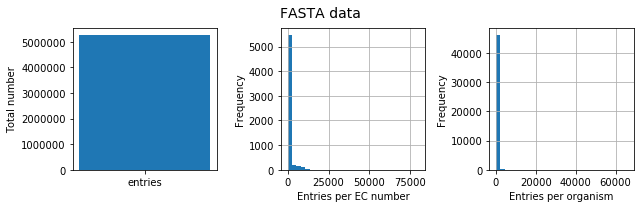

In [15]:

filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs.tsv')
df = pd.read_csv(filepath, sep='\t')

display(df.head())
display(df.tail())
display(df.describe())

fig = plt.figure(figsize=(9, 3))

st = fig.suptitle("FASTA data", fontsize=14)

plt.subplot(1, 3, 1)
plt.bar(x='entries', height=df['ec'].count(), width=0.3)
plt.ylabel('Total number')


plt.subplot(1, 3, 2)
df['ec'].value_counts().hist(bins=30)
plt.xlabel('Entries per EC number')
plt.ylabel('Frequency')


plt.subplot(1, 3, 3)
df['organism'].value_counts().hist(bins=30)
plt.xlabel('Entries per organism')
plt.ylabel('Frequency')

plt.tight_layout()

# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.85)

# (3)

## Third part entails getting superkingdom information for all sequences

### Specify function for getting superkingdom from organism name

In [16]:

def get_domain_of_life_from_org(data):
    '''
    Given a specific data structure finds domain of life based on organism names.
    This does not work for a number of organisms, so I need to do it based on uid as well in a different function.
    '''
    # first collect all the organisms
    all_orgs = []
    for ec in sorted(data.keys()):
        all_orgs.extend(data[ec].keys())
    all_orgs = sorted(list(set(all_orgs)))

    print('%s total organisms' % len(all_orgs))

    # get all the lineages
    lineage_object = org_tax.Lineage(input_type='organism', input_list=all_orgs)

    # put domain of life into the data structure
    for ec in sorted(data.keys()):
        for org in sorted(data[ec].keys()):
            domain = lineage_object.domain(org)
            if domain in ['None', None]:
                domain = 'Unknown'
            data[ec][org]['domain'] = domain
            
    return data


### Get information about superkingdoms for the parsed html data using organism names

**Generates:** The "ec_data_all_orgs_domain.tsv" and "ec_data_uid_orgs_domain.tsv" outfiles.

In [17]:

outfile_all = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_all_orgs_domain.tsv')
if not exists(outfile_all):
    ec_org_data = get_domain_of_life_from_org(ec_org_data)
    make_flatfile(ec_org_data, 'ec\torganism\tdomain', outfile_all, has_uid=False)
    
else:
    print('loading file')
    ec_org_data = load_flatfile(outfile_all, has_uid=False)

    
    
outfile_uid = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_uid_orgs_domain.tsv')
if not exists(outfile_uid):
    ec_org_uid_data = get_domain_of_life_from_org(ec_org_uid_data)
    make_flatfile(ec_org_uid_data, 'ec\torganism\tuid\tdomain', outfile_uid, has_uid=True)

else:
    print('loading file')
    ec_org_uid_data = load_flatfile(outfile_uid, has_uid=True)

loading file
loading file


#### Plot some figures for the html data data *without* identifiers

,ec,organism,domain
0,1.1.1.1,Acetobacter pasteurianus,Bacteria
1,1.1.1.1,Acinetobacter calcoaceticus,Bacteria
2,1.1.1.1,Aeropyrum pernix,Archaea
3,1.1.1.1,Alligator mississippiensis,Eukaryota
4,1.1.1.1,Anaerobium acetethylicum,Bacteria


,ec,organism,domain
69954,7.6.2.9,Escherichia coli,Bacteria
69955,7.6.2.9,Lactococcus lactis,Bacteria
69956,7.6.2.9,Listeria monocytogenes,Bacteria
69957,7.6.2.9,Pseudomonas syringae,Bacteria
69958,7.6.2.9,Salmonella enterica,Bacteria


,ec,organism,domain
count,69959,69959,69959
unique,6757,10148,5
top,4.1.1.39,Homo sapiens,Eukaryota
freq,300,1708,37907


,ec,organism
domain,,
Archaea,2770,2770
Bacteria,21540,21540
Eukaryota,37907,37907
Unknown,7564,7564
Viruses,178,178


Text(0.5, 0, 'Superkingdom')

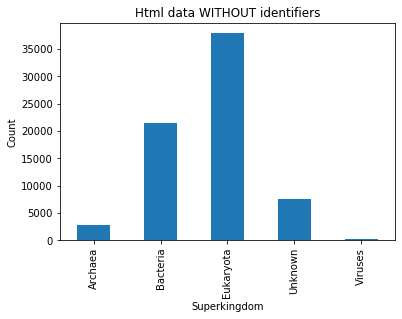

In [18]:
filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_all_orgs_domain.tsv')
df = pd.read_csv(filepath, sep='\t')

display(df.head())
display(df.tail())
display(df.describe())
display(df.groupby('domain').count())

df.groupby('domain').count()['ec'].plot(kind='bar')
plt.title('Html data WITHOUT identifiers')
plt.ylabel('Count')
plt.xlabel('Superkingdom')

#### Plot some figures for the html data data *with* identifiers

,ec,organism,uid,domain
0,1.1.1.1,Aeropyrum pernix,Q9Y9P9,Archaea
1,1.1.1.1,Anaerobium acetethylicum,A0A1D3TV27,Bacteria
2,1.1.1.1,Blastobotrys adeninivorans,A0A060TBM3,Eukaryota
3,1.1.1.1,Bombyx mori,Q1G151,Eukaryota
4,1.1.1.1,Candida albicans,A0A1D8PP43,Eukaryota


,ec,organism,uid,domain
33437,7.6.2.9,Bacillus subtilis,P46922,Bacteria
33438,7.6.2.9,Bacillus subtilis,O32243,Bacteria
33439,7.6.2.9,Lactococcus lactis,Q9KIF7,Bacteria
33440,7.6.2.9,Lactococcus lactis,Q7DAU8,Bacteria
33441,7.6.2.9,Pseudomonas syringae,Q87WH5,Bacteria


,ec,organism,uid,domain
count,33442,33442,33442,33442
unique,5150,4152,31287,5
top,2.7.11.1,Homo sapiens,Q975F9,Eukaryota
freq,336,2636,11,18903


,ec,organism,uid
domain,,,
Archaea,1963,1963,1963
Bacteria,10123,10123,10123
Eukaryota,18903,18903,18903
Unknown,2400,2400,2400
Viruses,53,53,53


Text(0.5, 0, 'Superkingdom')

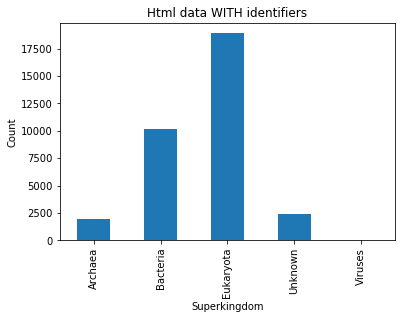

In [19]:

filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_uid_orgs_domain.tsv')
df = pd.read_csv(filepath, sep='\t')

display(df.head())
display(df.tail())
display(df.describe())
display(df.groupby('domain').count())

df.groupby('domain').count()['ec'].plot(kind='bar')
plt.title('Html data WITH identifiers')
plt.ylabel('Count')
plt.xlabel('Superkingdom')

### Get information about superkingdoms for the parsed fasta data using organism names

**Generates:** The "fasta_data_ec_uid_orgs_domain.tsv" outfile.

In [20]:

# get domain of life

outfile_all = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs_domain.tsv')
if not exists(outfile_all):
    fasta_data = get_domain_of_life_from_org(fasta_data)
    make_flatfile(fasta_data, 'ec\torganism\tuid\tdomain', outfile_all, has_uid=True)
    
else:
    print('loading file')
    fasta_data = load_flatfile(outfile_all, has_uid=True)



loading file


#### Plot some figures for the fasta data

,ec,organism,uid,domain
0,1.1.1.1,Acetatifactor muris,A0A2K4ZQ23,Bacteria
1,1.1.1.1,Acetobacter ghanensis,A0A0U5F2U0,Bacteria
2,1.1.1.1,Acetobacter ghanensis,A0A0U5F1E8,Bacteria
3,1.1.1.1,Acetobacter ghanensis,A0A0U5F7X9,Bacteria
4,1.1.1.1,Acetobacter malorum,A0A087PPJ3,Bacteria


,ec,organism,uid,domain
5279550,7.6.2.9,metagenome,A0A2P2C2K9,Unknown
5279551,7.6.2.9,mine drainage,A0A1J5Q5U1,Unknown
5279552,7.6.2.9,mine drainage,A0A1J5QLZ0,Unknown
5279553,7.6.2.9,uncultured Clostridiales,A0A212JCP2,Unknown
5279554,7.6.2.9,uncultured bacterium,A0A1C9V0R0,Unknown


,ec,organism,uid,domain
count,5279555,5279555,5279555,5279555
unique,6040,46464,5067256,5
top,3.6.4.12,Gammaproteobacteria bacterium,A0A2C8CXA6,Bacteria
freq,80199,65759,17,2964597


,ec,organism,uid
domain,,,
Archaea,99553,99553,99553
Bacteria,2964597,2964597,2964597
Eukaryota,511680,511680,511680
Unknown,1702064,1702064,1702064
Viruses,1661,1661,1661


Text(0.5, 0, 'Superkingdom')

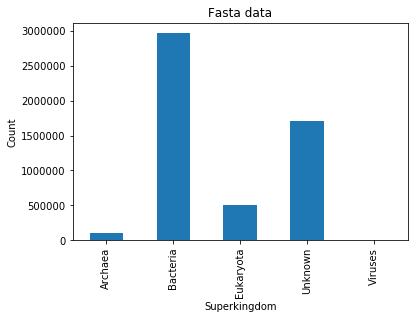

In [21]:
filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs_domain.tsv')
df = pd.read_csv(filepath, sep='\t')

display(df.head())
display(df.tail())
display(df.describe())
display(df.groupby('domain').count())

df.groupby('domain').count()['ec'].plot(kind='bar')
plt.title('Fasta data')
plt.ylabel('Count')
plt.xlabel('Superkingdom')

## Get superkingdom using uniprot identifiers instead of organism name

#### Specify functions for getting superkingdom from uniprot identifiers 

In [22]:
def load_org_domain_data(filepath):
    uid_to_domain = {}
    if exists(filepath):
        with open(filepath, 'r') as f:
            f.readline()
            for line in f:
                uid, domain = line.strip().split('\t')
                uid_to_domain[uid] = domain
    return uid_to_domain



def save_org_domain_data(data, filepath):
    out_data = ['organism\tdomain']
    for uid in sorted(data.keys()):
        out_data.append('%s\t%s' % (uid, data[uid]))
        
    with open(filepath, 'w') as f:
        f.write('\n'.join(out_data))
    
    

def get_domain_of_life_from_uid(data, batch_size=100):
    '''
    For the cases where I cannot get the domain of life from the organism name, 
    try to get it from the identifiers.
    '''
    # first collect all the organisms and one sequence identifier for each
    all_orgs = set([])
    all_uids = []
    uid_to_org = {}
    for ec in sorted(data.keys()):
        for org in sorted(data[ec].keys()):
            if data[ec][org]['domain'] in [None, 'Unknown']:
                if org not in all_orgs:
                    all_orgs.add(org)
                    uid = list(data[ec][org]['uids'])[0]
                    uid_to_org[uid] = org
                    all_uids.append(uid)
                    
    print('Total %s lookups to do' % len(all_uids))
    
    # first load any pre-downloaded results (in case script has crashed or the computation was done already)
    data_file = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'org_to_domain.tsv')
    if exists(data_file):
        org_to_domain = load_org_domain_data(data_file)
    else:
        org_to_domain = {}

    # now download the rest
    counter = 0
    uid_list = []
    for uid in tqdm(all_uids):
        
        # check whether I already have the info for this organism
        if uid_to_org[uid] in org_to_domain.keys():
            continue
        
        counter += 1
        uid_list.append(uid)
        
        if counter == batch_size:
            uid_to_taxid = uid_tax.get_taxid(uid_list) # get uid to taxid translation

            # get all the lineages from taxids
            lineage_object = org_tax.Lineage(input_type='taxid', input_list=sorted(uid_to_taxid.values()))
            
            # put domain of life into the data structure
            for uid in sorted(uid_to_taxid.keys()):
                taxid = uid_to_taxid[uid]
                                    
                domain = lineage_object.domain(uid_to_taxid[uid])
                
                # don't want any strange superkingdom names
                if domain not in ['Eukaryota', 'Bacteria', 'Archaea', 'Viruses']:
                    domain = 'Unknown'
                
                org_to_domain[uid_to_org[uid]] = domain        
            
            # save in case of crash
            save_org_domain_data(org_to_domain, data_file)
            
            counter = 0
            uid_list = []
            
    ## catch the last ones ##
    uid_to_taxid = uid_tax.get_taxid(uid_list) # get uid to taxid translation
      
    # get all the lineages from taxids
    lineage_object = org_tax.Lineage(input_type='taxid', input_list=sorted(uid_to_taxid.values()))

    # put domain of life into the data structure
    for uid in sorted(uid_to_taxid.keys()):
        domain = lineage_object.domain(uid_to_taxid[uid])
        org_to_domain[uid_to_org[uid]] = domain        

    # save in case of crash
    save_org_domain_data(org_to_domain, data_file)
        
    # add in the new domain annotation
    for ec in sorted(data.keys()):
        for org in sorted(data[ec].keys()):
            if data[ec][org]['domain'] in [None, 'None', 'Unknown']:
                if org_to_domain.get(org) is None:
                    data[ec][org]['domain'] = 'Unknown'
                else:
                    data[ec][org]['domain'] = org_to_domain[org]
                
    return data

  

#### For the the organisms with unknown superkingdom in the html dataset with identifiers, try to get that information using uniprot identifiers

**Generates:** The "ec_data_uid_orgs_domain_2.tsv" outfile.

In [23]:
outfile_uid = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_uid_orgs_domain_2.tsv')

ec_org_uid_data = get_domain_of_life_from_uid(ec_org_uid_data)
make_flatfile(ec_org_uid_data, 'ec\torganism\tuid\tdomain', outfile_uid, has_uid=True)

100%|██████████| 480/480 [00:00<00:00, 1202667.81it/s]

Total 480 lookups to do


getting lineages
done


#### Plot some figures for the html data with identifiers

,ec,organism,uid,domain
0,1.1.1.1,Aeropyrum pernix,Q9Y9P9,Archaea
1,1.1.1.1,Anaerobium acetethylicum,A0A1D3TV27,Bacteria
2,1.1.1.1,Blastobotrys adeninivorans,A0A060TBM3,Eukaryota
3,1.1.1.1,Bombyx mori,Q1G151,Eukaryota
4,1.1.1.1,Candida albicans,A0A1D8PP43,Eukaryota


,ec,organism,uid,domain
33437,7.6.2.9,Bacillus subtilis,P46922,Bacteria
33438,7.6.2.9,Bacillus subtilis,O32243,Bacteria
33439,7.6.2.9,Lactococcus lactis,Q9KIF7,Bacteria
33440,7.6.2.9,Lactococcus lactis,Q7DAU8,Bacteria
33441,7.6.2.9,Pseudomonas syringae,Q87WH5,Bacteria


,ec,organism,uid,domain
count,33442,33442,33442,33442
unique,5150,4152,31287,5
top,2.7.11.1,Homo sapiens,Q975F9,Eukaryota
freq,336,2636,11,19160


,ec,organism,uid
domain,,,
Archaea,2175,2175,2175
Bacteria,11738,11738,11738
Eukaryota,19160,19160,19160
Unknown,81,81,81
Viruses,288,288,288


Text(0.5, 0, 'Superkingdom')

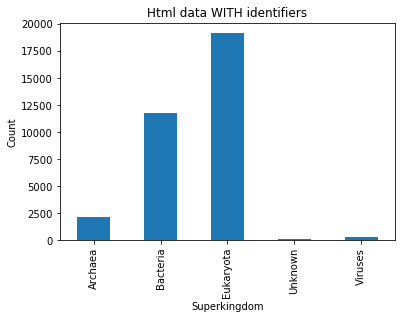

In [24]:

filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_uid_orgs_domain_2.tsv')
df_html_uid = pd.read_csv(filepath, sep='\t')

display(df_html_uid.head())
display(df_html_uid.tail())
display(df_html_uid.describe())
display(df_html_uid.groupby('domain').count())

df_html_uid.groupby('domain').count()['ec'].plot(kind='bar')
plt.title('Html data WITH identifiers')
plt.ylabel('Count')
plt.xlabel('Superkingdom')

#### For the the organisms with unknown superkingdom in the fasta dataset, try to get that information using uniprot identifiers

**Generates:** The "fasta_data_uid_orgs_domain_2.tsv" outfile.

In [ ]:

outfile_fasta = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs_domain_2.tsv')

fasta_data = get_domain_of_life_from_uid(fasta_data)
make_flatfile(fasta_data, 'ec\torganism\tuid\tdomain', outfile_fasta, has_uid=True)

100%|██████████| 8724/8724 [00:00<00:00, 1772395.65it/s]

Total 8724 lookups to do
Retrieving taxids for UniprotId 0 to 2 from UniProtKb ...


Done
Retrieving 2 obsolete/redundant taxids from UniParc ...


#### Plot some figures for the fasta data

In [ ]:
filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs_domain_2.tsv')
df_fasta = pd.read_csv(filepath, sep='\t')

display(df_fasta.head())
display(df_fasta.tail())
display(df_fasta.describe())
display(df_fasta.groupby('domain').count())

df_fasta.groupby('domain').count()['ec'].plot(kind='bar')
plt.title('Fasta data')
plt.ylabel('Count')
plt.xlabel('Superkingdom')

#### Finally, for the html dataset without any uniprot identifiers, try to use the newly downloaded uid-based data (more organism-superkingdom pairs) to update annotation

**Generates:** The "ec_data_all_orgs_domain_2.tsv" file.

In [ ]:
def alternate_domain_of_life_from_org(data):
    '''
    '''
    # first load any pre-downloaded results (in case script has crashed or the computation was done already)
    data_file = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'org_to_domain.tsv')
    org_to_domain = load_org_domain_data(data_file)

    # add in the new domain annotation
    for ec in sorted(data.keys()):
        for org in sorted(data[ec].keys()):
            if data[ec][org]['domain'] in [None, 'None', 'Unknown']:
                if org_to_domain.get(org) is None:
                    data[ec][org]['domain'] = 'Unknown'
                else:
                    data[ec][org]['domain'] = org_to_domain[org]
    return data

                
                
### add code here to re-use the information about the organism names ####
infile = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_all_orgs_domain.tsv')
outfile = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_all_orgs_domain_2.tsv')


ec_org_data = alternate_domain_of_life_from_org(ec_org_data)
make_flatfile(ec_org_data, 'ec\torganism\tdomain', outfile, has_uid=False)

#### Plot some figures for the html data witout identifiers

In [ ]:
filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_all_orgs_domain_2.tsv')
df_html = pd.read_csv(filepath, sep='\t')

display(df_html.head())
display(df_html.tail())
display(df_html.describe())
display(df_html.groupby('domain').count())

df_html.groupby('domain').count()['ec'].plot(kind='bar')
plt.title('Html data WITHOUT identifiers')
plt.ylabel('Count')
plt.xlabel('Superkingdom')